In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/content/drive/MyDrive/dataset/covid_wikipedia_tables.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,Date,West,Midwest,South,Northeast,Territories,Date,Confirmed,Deaths,Recovered,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,VI,New,Cml,New,Cml,New,Cml,Cml,NaN,NaN
2,Jan 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jan 21,1,1,NaN,NaN,NaN,NaN,1
3,Jan 24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jan 24,1,2,NaN,NaN,NaN,NaN,2
4,Jan 25,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jan 25,1,3,NaN,NaN,NaN,NaN,3


In [3]:
df.shape

(258, 64)

In [4]:
## df Contains Both Tables, the First Table Contains Cases
cases = df.copy()

## Drop the First Row Filled with Misplaced Headers
cases.drop(0, axis=0, inplace=True)

## Drop the Extra Date Column
cases.drop('56', axis=1, inplace=True)

## Set Up the Proper Column Names
col_names = ['Date']
col_names = col_names + list(cases.loc[1])
col_names = [x for x in col_names if str(x) != 'nan']

col_names[56] = 'Confirmed New'
col_names[57] = 'Confirmed Cml'
col_names[58] = 'Deaths New'
col_names[59] = 'Deaths Cml'
col_names[60] = 'Recovered New'
col_names[61] = 'Recovered Cml'
last_col = ['Active Cml']
col_names = col_names + last_col
cases.columns = col_names

## Drop Rows with Extra Column Headers
rows_to_drop = [1,18,19,51,52,83,84,116,117,148,149,181,182,214,215,246,247,251,252,253,254,255,256,257]

for row in rows_to_drop:
    cases.drop(row, axis=0, inplace=True)

## Fill Nans with 0
cases.fillna(0, inplace=True)

## Convert Dates from String to Datetime
import datetime as dt

cases['Date'] = [dt.datetime.strptime(d + ' 2020', '%b %d %Y') for d in cases['Date']]
cases.reset_index(drop=True, inplace=True)
cases.set_index('Date', inplace=True)
cases=cases.astype(float)
print(len(cases))

233


In [5]:
cases.head()

,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,MP,PR,VI,Confirmed New,Confirmed Cml,Deaths New,Deaths Cml,Recovered New,Recovered Cml,Active Cml
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0
2020-01-25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0
2020-01-26,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,5.0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,6.0


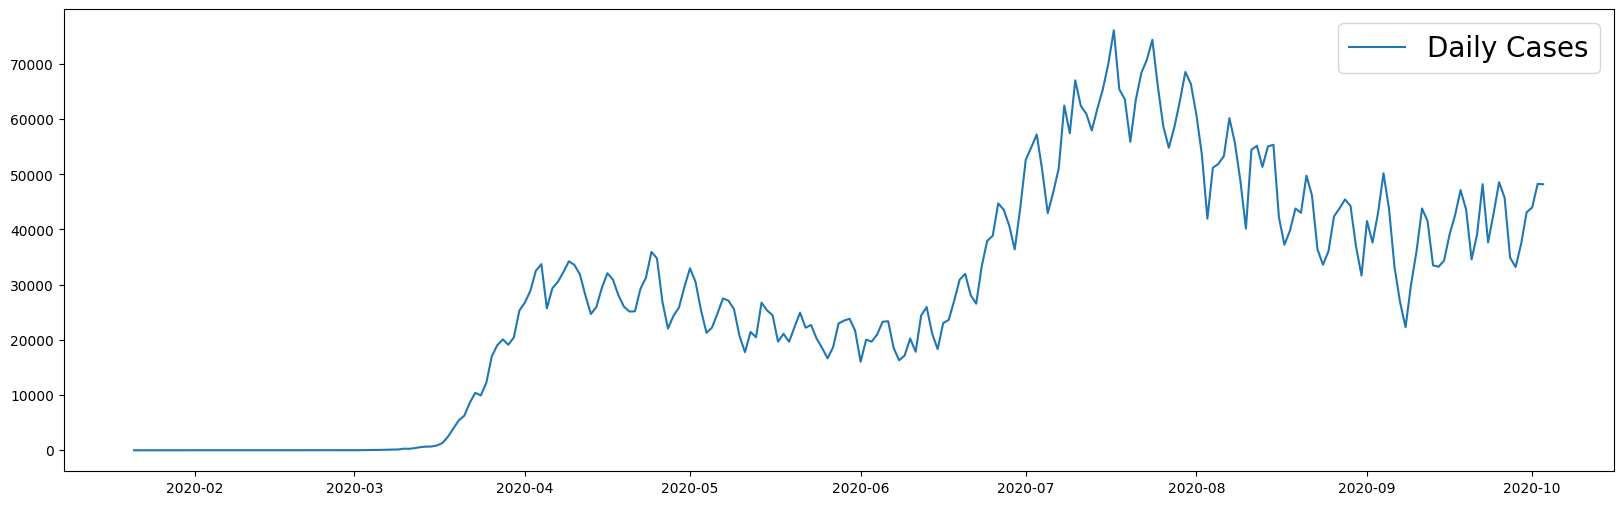

In [6]:
# Plot Daily Cases
plt.figure(figsize=(20,6))
plt.plot(cases.index.values, cases['Confirmed New'], label = 'Daily Cases')
plt.legend(prop={'size': 20})
plt.show()

In [7]:
len(cases.index.values)

233

In [8]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [9]:
# Evaluate an ARIMA Model for a Given Order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [10]:
# Evaluate Combinations of p, d and q Values for an ARIMA Model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    rmse = np.sqrt(mse)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
hyper_fitting = cases

p_values = [5, 6, 7, 8, 9, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(hyper_fitting['Confirmed New'].values, p_values, d_values, q_values)

ARIMA(5, 0, 0) RMSE=5596.708
ARIMA(5, 0, 1) RMSE=5448.589
ARIMA(5, 0, 2) RMSE=5260.088
ARIMA(5, 1, 0) RMSE=5166.242
ARIMA(5, 1, 1) RMSE=5186.269
ARIMA(5, 1, 2) RMSE=4728.100
ARIMA(5, 2, 0) RMSE=6641.659
ARIMA(5, 2, 1) RMSE=5115.582
ARIMA(5, 2, 2) RMSE=5036.013
ARIMA(6, 0, 0) RMSE=5156.142
ARIMA(6, 0, 1) RMSE=5199.291
ARIMA(6, 0, 2) RMSE=4820.270
ARIMA(6, 1, 0) RMSE=5288.576
ARIMA(6, 1, 2) RMSE=4593.887
ARIMA(6, 2, 0) RMSE=5048.262
ARIMA(6, 2, 1) RMSE=4621.118
ARIMA(6, 2, 2) RMSE=4642.261
ARIMA(7, 0, 0) RMSE=5279.061
ARIMA(7, 0, 1) RMSE=5028.968
ARIMA(7, 0, 2) RMSE=4764.194
ARIMA(7, 1, 0) RMSE=4747.516
ARIMA(7, 1, 1) RMSE=4522.360
ARIMA(7, 1, 2) RMSE=4535.617
ARIMA(7, 2, 0) RMSE=4649.131
ARIMA(7, 2, 1) RMSE=4620.733
ARIMA(7, 2, 2) RMSE=4653.464
ARIMA(8, 0, 0) RMSE=4743.891
ARIMA(8, 0, 1) RMSE=4503.628
ARIMA(8, 0, 2) RMSE=4468.799
ARIMA(8, 1, 0) RMSE=4508.922
ARIMA(8, 1, 1) RMSE=4497.426
ARIMA(8, 1, 2) RMSE=4570.308
ARIMA(8, 2, 0) RMSE=4631.425
ARIMA(8, 2, 1) RMSE=4548.593
ARIMA(8, 2, 2)

In [11]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def pred_and_plot(days):
    X = cases['Confirmed New'].values

    train_size = len(X)-days
    train, test = X[0:train_size], X[train_size:]
    train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    # for t in range(len(test)):

    model = ARIMA(history, order=(9,0,0))
    model_fit = model.fit()
    yhats = model_fit.forecast(steps=len(test))

    print('Number of Days predicted: %s' % days)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(15,8))

    plt.plot(train_time, train, label='training', linewidth=3)

    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats,0,train[-1]), label='predicted')


    plt.legend(prop={'size': 20})

    rmse = np.sqrt(mean_squared_error(test, yhats))
    print('RMSE=%.3f' % rmse)

    plt.show()

    return rmse

Number of Days predicted: 5
RMSE=6231.305


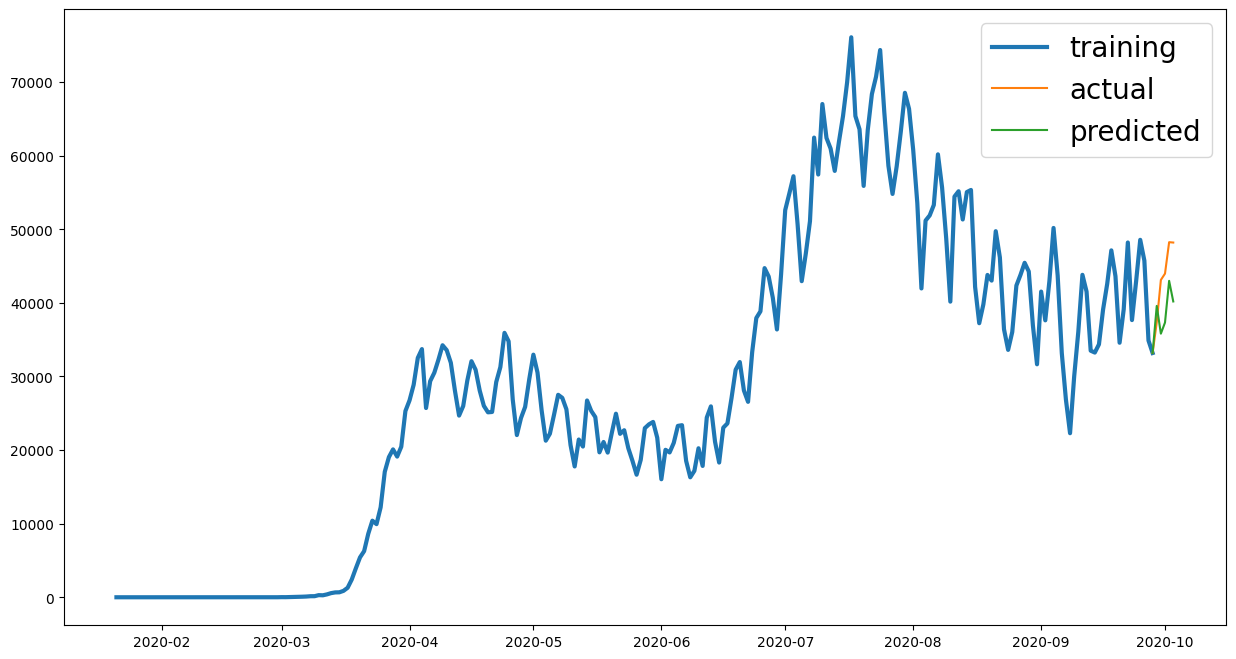

Number of Days predicted: 10
RMSE=4298.347


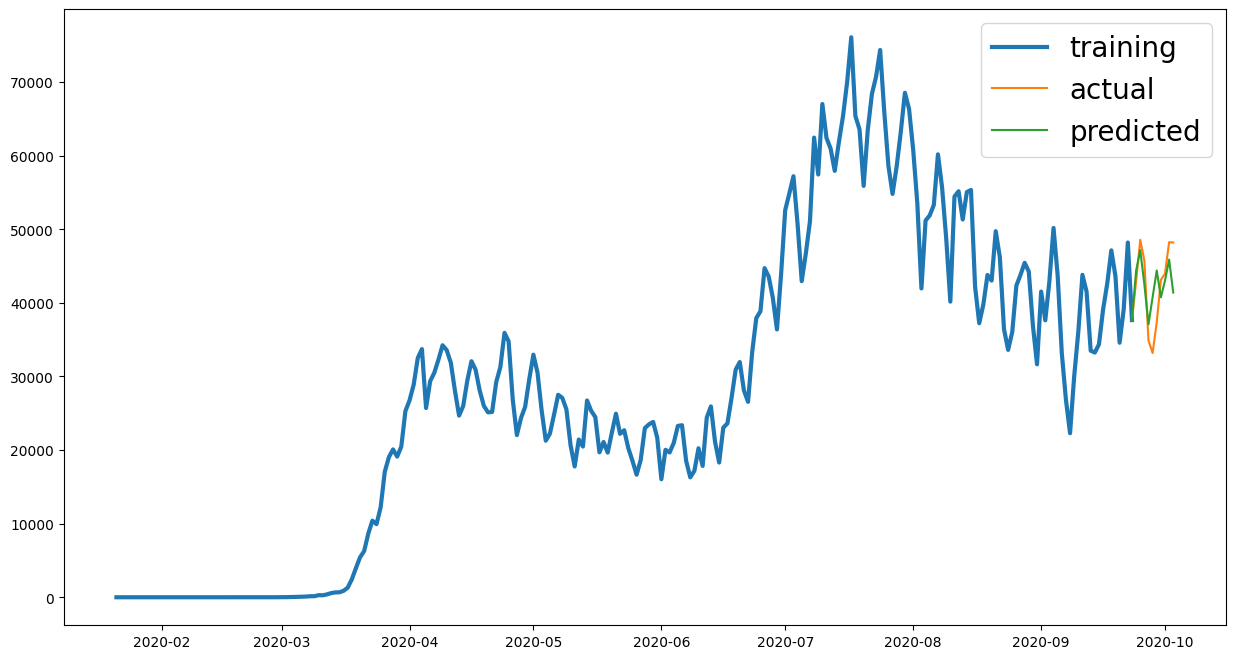

Number of Days predicted: 20
RMSE=10490.762


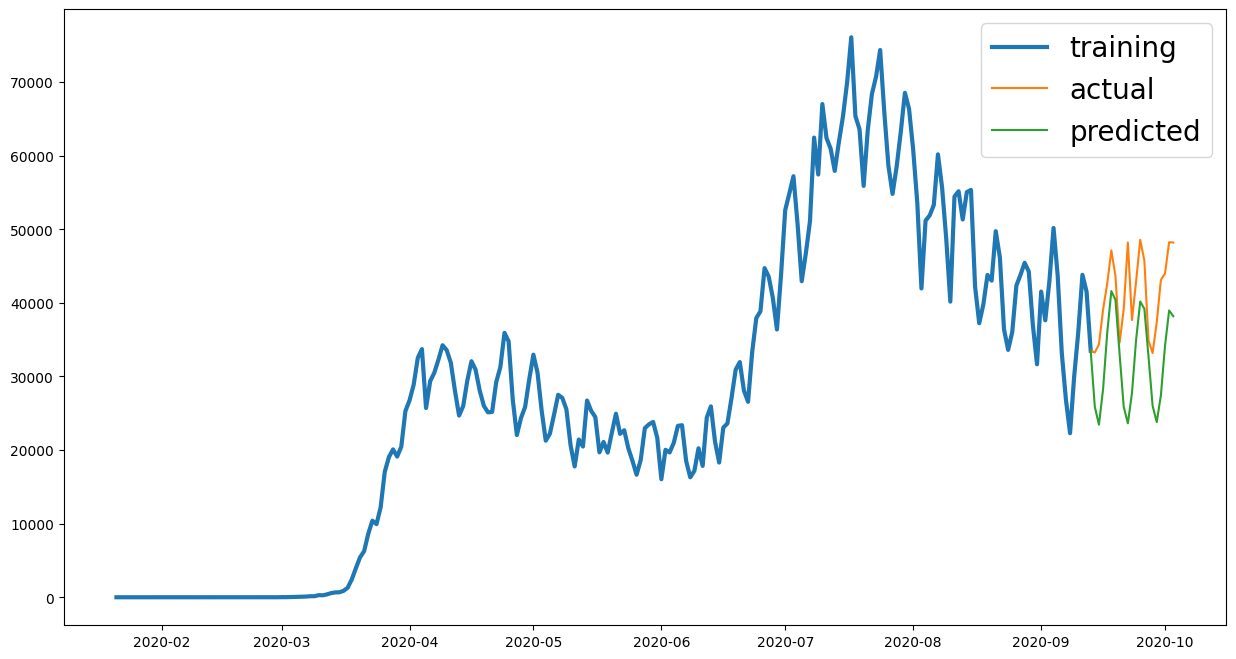

Number of Days predicted: 30
RMSE=7541.562


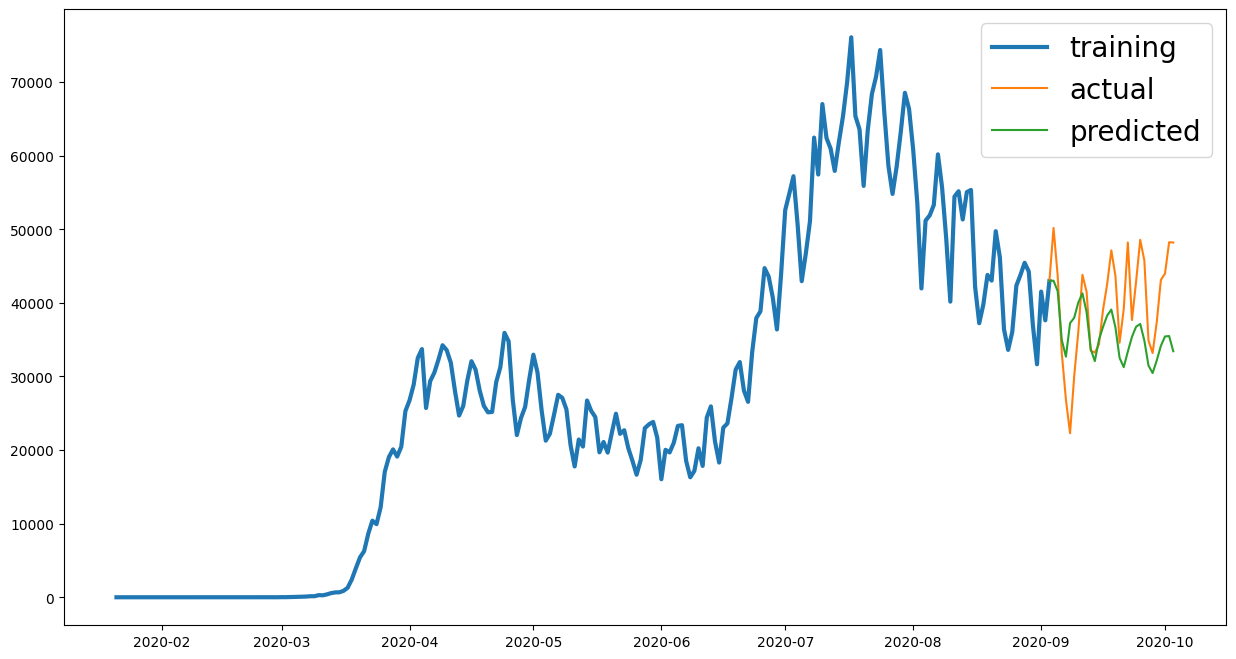

Number of Days predicted: 60
RMSE=15201.898


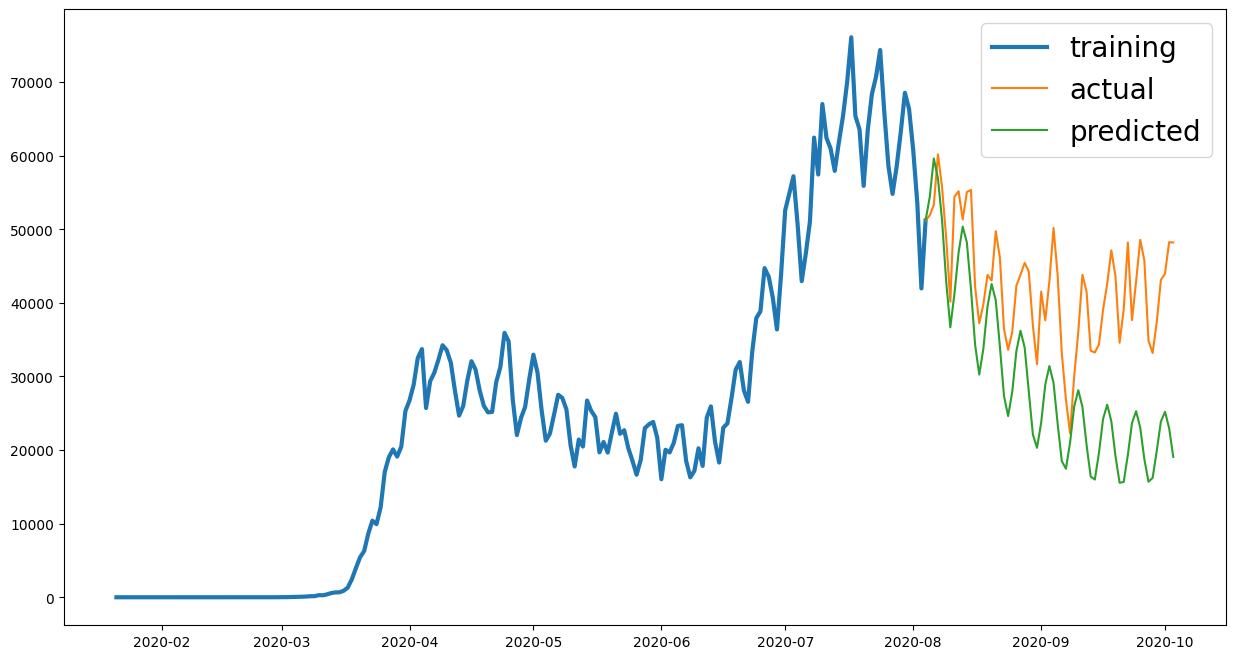

Number of Days predicted: 100
RMSE=25574.826


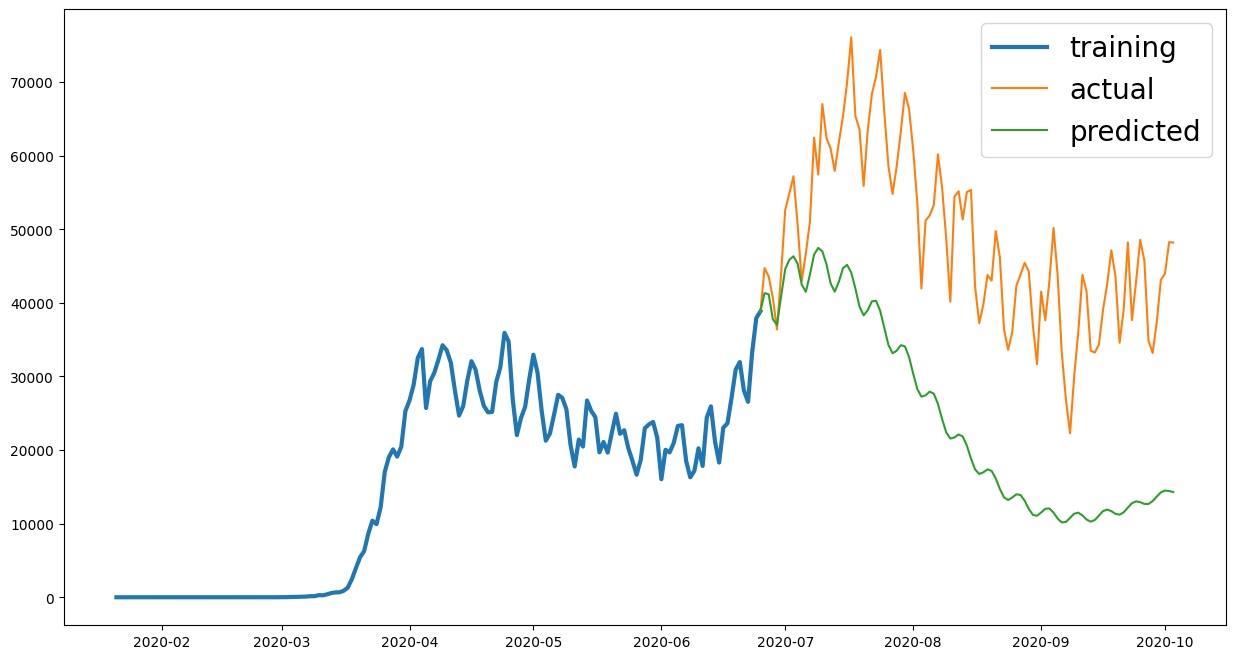

In [12]:
num_days_predicted = [5,10,20,30,60,100]
rmse_plain = []

for days in num_days_predicted:
    rmse = pred_and_plot(days)
    rmse_plain.append(rmse)

In [13]:
# Autoregression (AR)

import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def pred_and_plot(days):

    X = cases['Confirmed New'].values
    train_size = len(X)-days
    train, test = X[0:train_size], X[train_size:]
    train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()

    model = AutoReg(history, lags=1)
    model_fit = model.fit()
    yhats = model_fit.forecast(steps=len(test))

    print('Number of Days predicted: %s' % days)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(15,8))

    plt.plot(train_time, train, label='training', linewidth=3)

    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats,0,train[-1]), label='predicted')


    plt.legend(prop={'size': 20})

    rmse = np.sqrt(mean_squared_error(test, yhats))
    print('RMSE=%.3f' % rmse)

    plt.show()

    return rmse

Number of Days predicted: 5
RMSE=11493.887


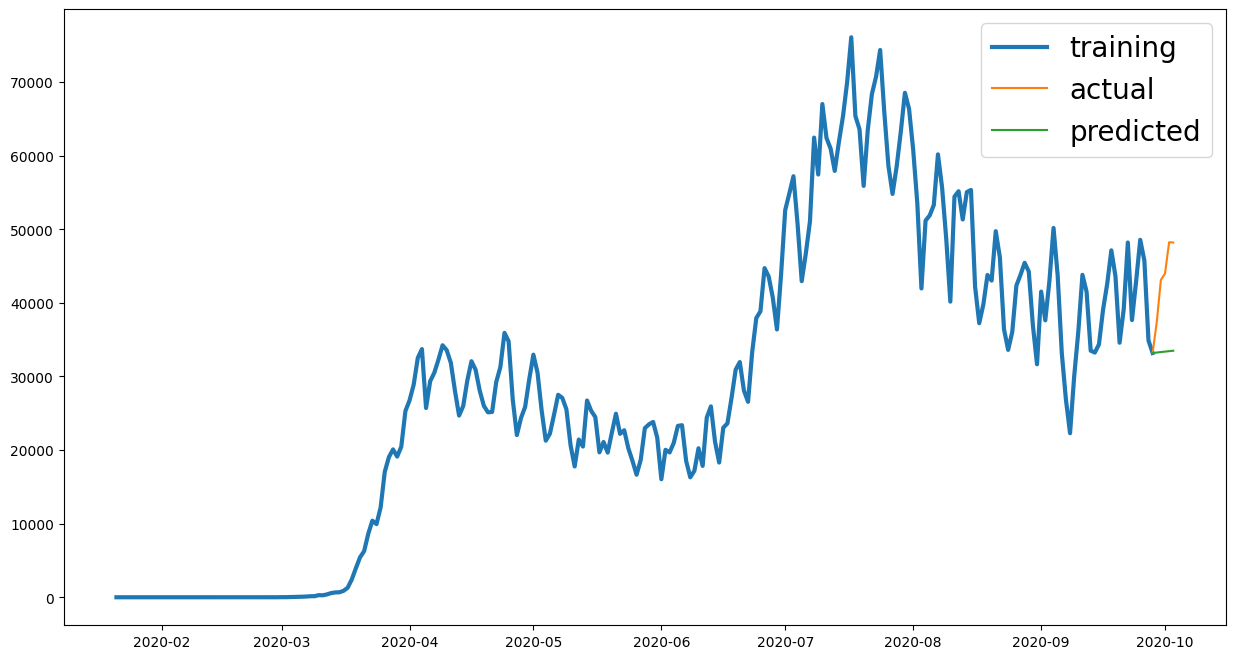

Number of Days predicted: 10
RMSE=7508.066


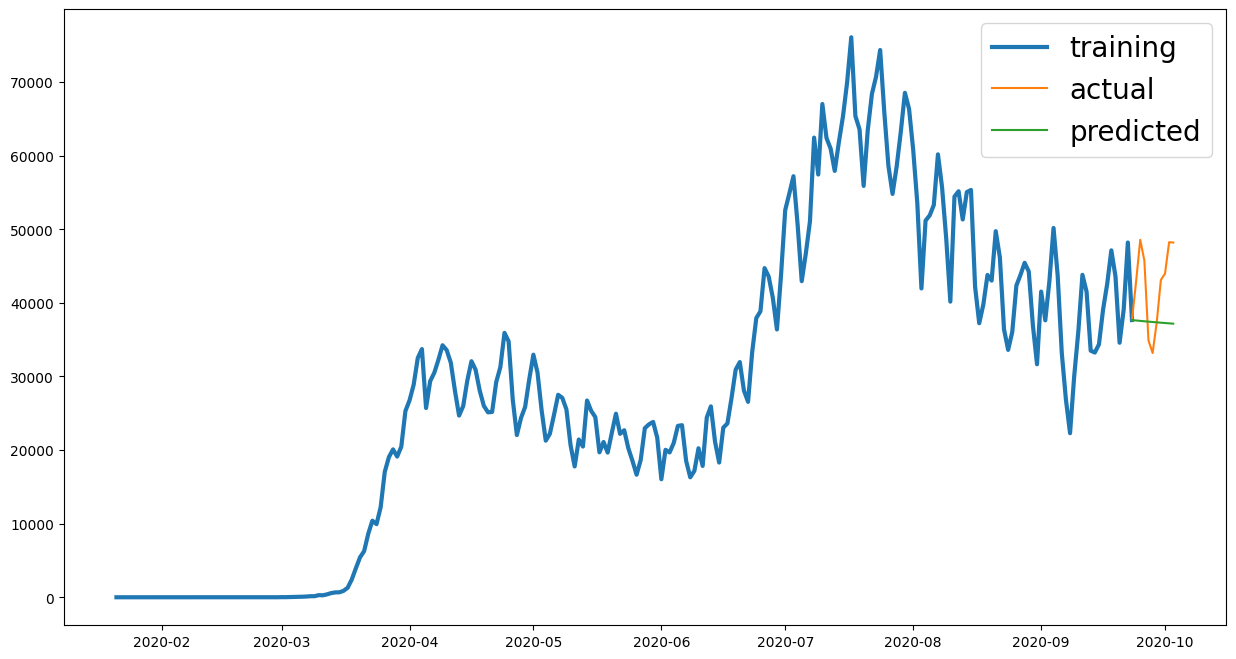

Number of Days predicted: 20
RMSE=9005.924


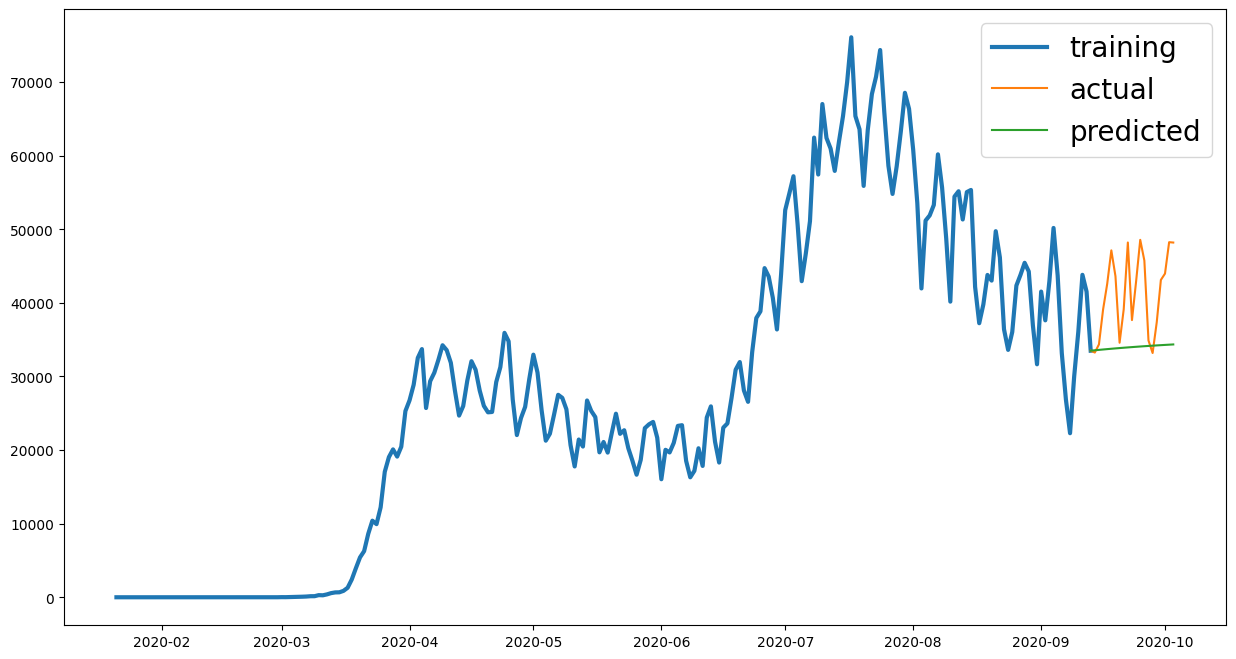

Number of Days predicted: 30
RMSE=7445.695


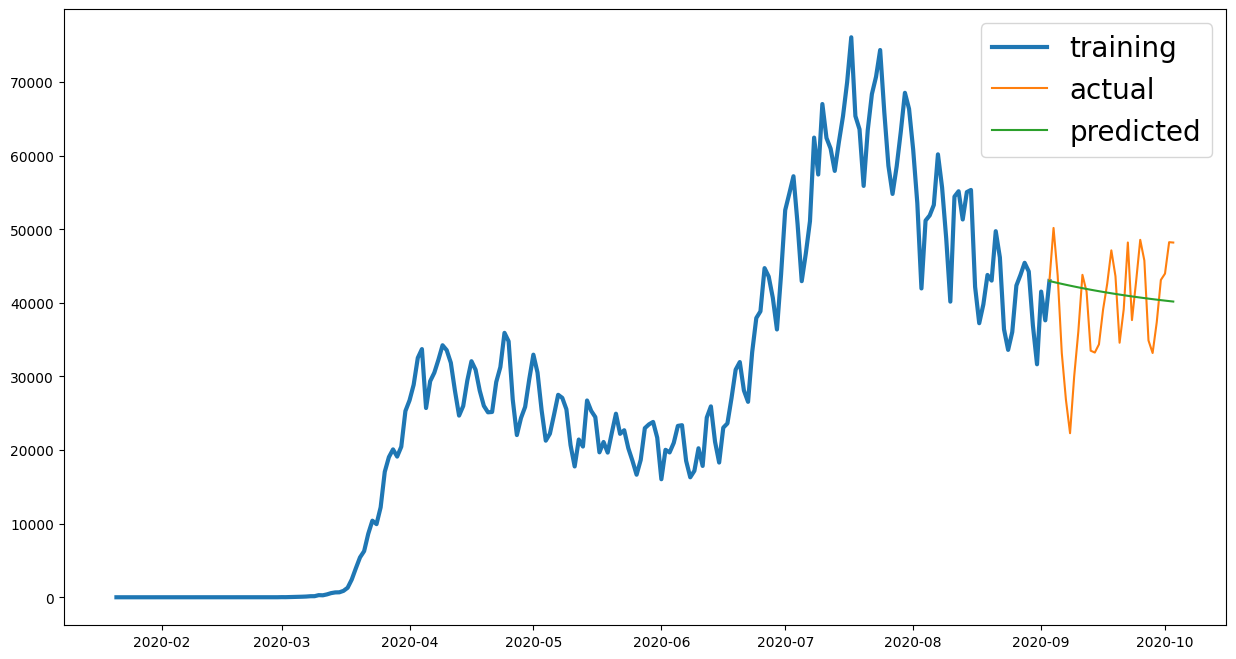

Number of Days predicted: 60
RMSE=9073.638


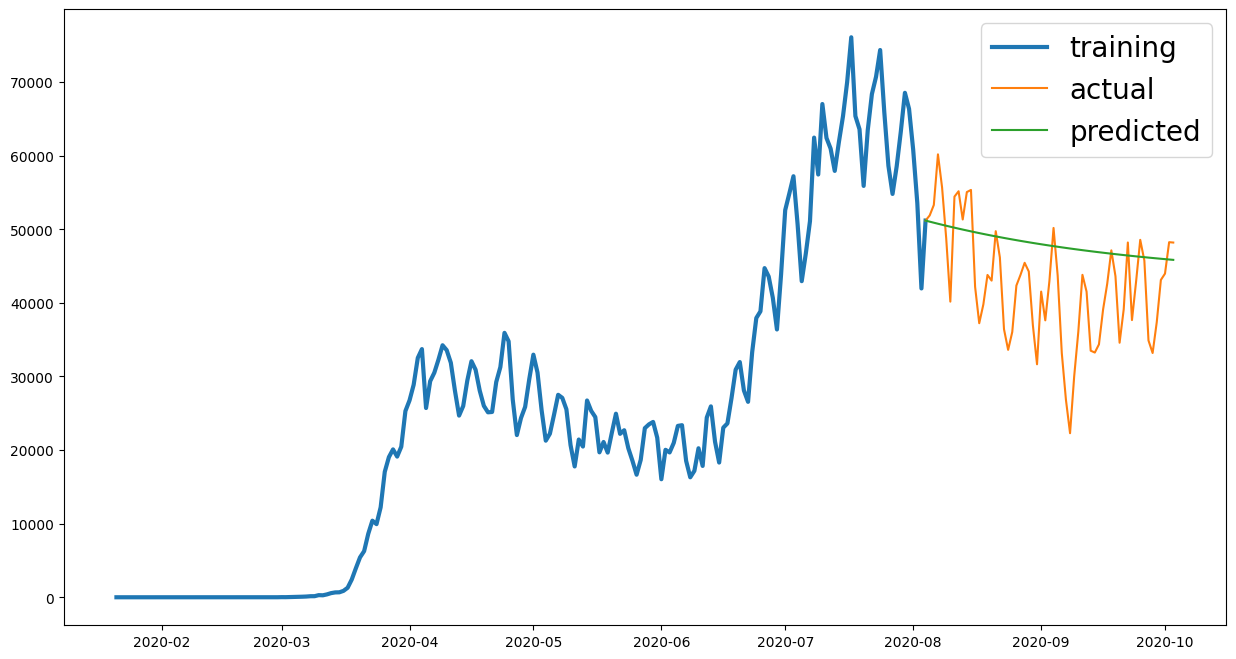

Number of Days predicted: 100
RMSE=18110.884


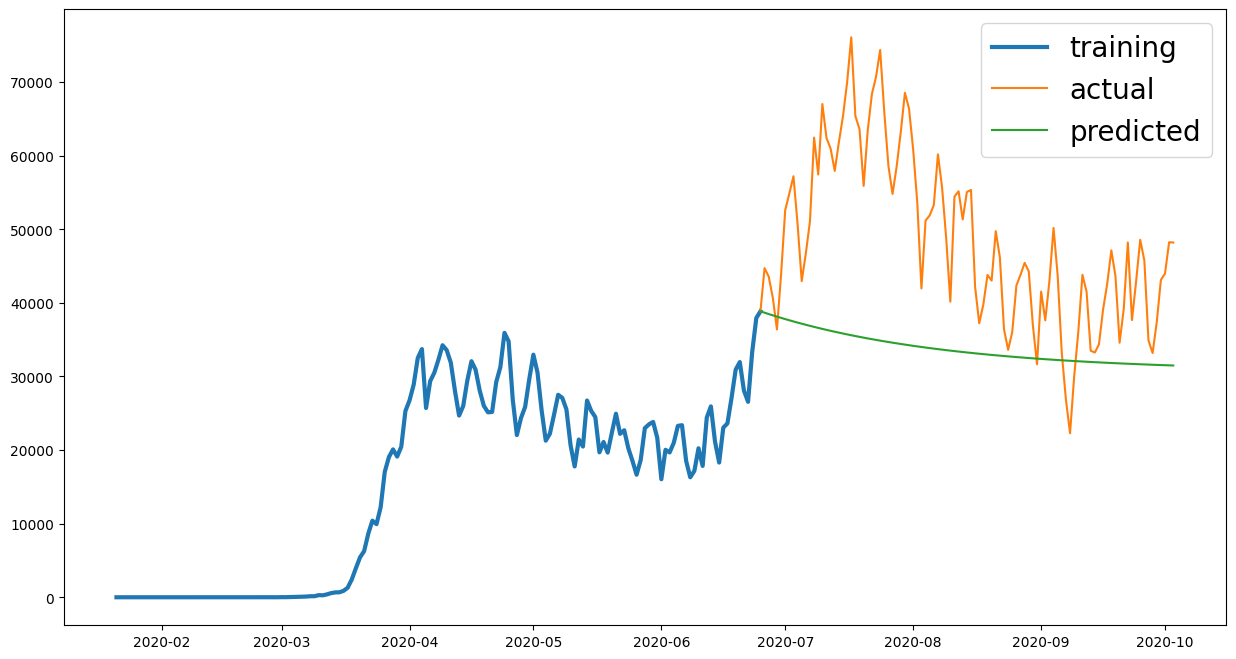

In [14]:
num_days_predicted = [5,10,20,30,60,100]
rmse_plain = []

for days in num_days_predicted:
    rmse = pred_and_plot(days)
    rmse_plain.append(rmse)

In [18]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima -q
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])
df['#Passengers_diff'] = df['#Passengers'].diff(periods=12)
df['#Passengers_diff'].fillna(method='backfill', inplace=True)
df['month_index'] = df.index.month ## exogenous variable

SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index": pd.date_range(df.index[-1], periods=n_periods, freq='MS').month},
                               index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()


#df.head(20)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00


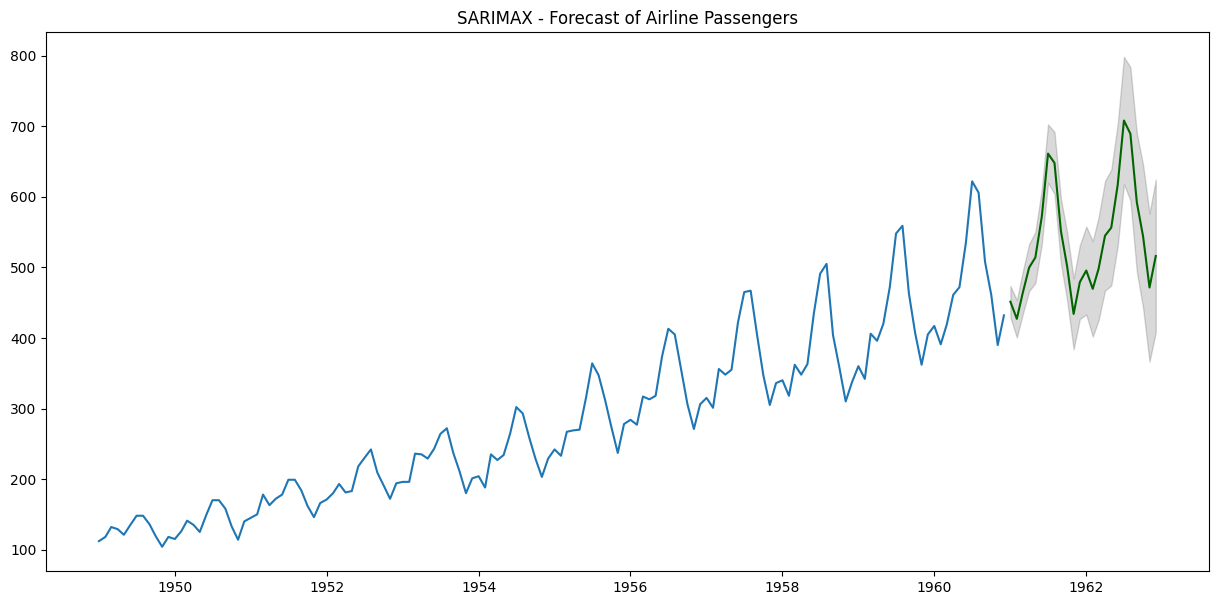

In [19]:
sarimax_forecast(SARIMAX_model, periods=24)